### Based on https://arxiv.org/pdf/1707.05409.pdf

In [1]:
import tensorflow as tf
import time
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import os
import collections
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold

/home/daniil_chuykin/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Preprocessing

In [2]:
train_data = pd.read_csv('/home/daniil_chuykin/train.csv')

In [3]:
train_data.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


In [4]:
print(train_data.shape)

(404290, 6)


In [5]:
train_data.isnull().values.any()

True

In [6]:
train_data.dropna(inplace=True)

In [7]:
train_data.isnull().values.any()

False

In [8]:
print(train_data.shape)

(404287, 6)


In [9]:
first_len = train_data[train_data['is_duplicate'] == 1].shape[0]
second_len = train_data[train_data['is_duplicate'] == 0].shape[0]

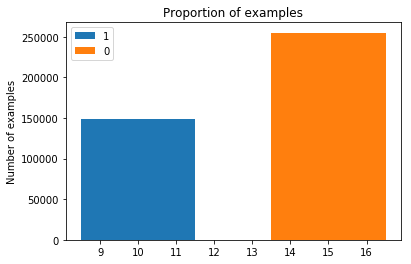

In [10]:
plt.bar(10,first_len,3, label="1")
plt.bar(15,second_len,3, label="0")
plt.legend()
plt.ylabel('Number of examples')
plt.title('Proportion of examples')
plt.show()

In [11]:
def remove_punctuation(text):
    '''a function for removing punctuation'''
    import string
    
    translator = str.maketrans('', '', string.punctuation)
    
    return text.translate(translator)

In [12]:
train_data['question1'] = train_data['question1'].apply(remove_punctuation)
train_data['question2'] = train_data['question2'].apply(remove_punctuation)

In [13]:
train_data.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor KohiNoor Diamond,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely How can I solve it,Find the remainder when math2324math is divide...,0
4,4,9,10,Which one dissolve in water quikly sugar salt ...,Which fish would survive in salt water,0
5,5,11,12,Astrology I am a Capricorn Sun Cap moon and ca...,Im a triple Capricorn Sun Moon and ascendant i...,1
6,6,13,14,Should I buy tiago,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist,What should I do to be a great geologist,1
8,8,17,18,When do you use シ instead of し,When do you use instead of and,0
9,9,19,20,Motorola company Can I hack my Charter Motorol...,How do I hack Motorola DCX3400 for free internet,0


In [14]:
sw = stopwords.words('english')

In [15]:
def stopwords(text):
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)

In [16]:
train_data['question1'] = train_data['question1'].apply(stopwords)
train_data['question2'] = train_data['question2'].apply(stopwords)

In [17]:
train_data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,step step guide invest share market india,step step guide invest share market,0
1,1,3,4,story kohinoor kohinoor diamond,would happen indian government stole kohinoor ...,0
2,2,5,6,increase speed internet connection using vpn,internet speed increased hacking dns,0
3,3,7,8,mentally lonely solve,find remainder math2324math divided 2423,0
4,4,9,10,one dissolve water quikly sugar salt methane c...,fish would survive salt water,0


In [18]:
stemmer = SnowballStemmer("english")

def stemming(text):    
    '''a function which stems each word in the given text'''
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text) 

In [19]:
train_data['question1'] = train_data['question1'].apply(stemming)
train_data['question2'] = train_data['question2'].apply(stemming)
train_data.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,step step guid invest share market india,step step guid invest share market,0
1,1,3,4,stori kohinoor kohinoor diamond,would happen indian govern stole kohinoor kohi...,0
2,2,5,6,increas speed internet connect use vpn,internet speed increas hack dns,0
3,3,7,8,mental lone solv,find remaind math2324math divid 2423,0
4,4,9,10,one dissolv water quik sugar salt methan carbo...,fish would surviv salt water,0
5,5,11,12,astrolog capricorn sun cap moon cap risingwhat...,im tripl capricorn sun moon ascend capricorn say,1
6,6,13,14,buy tiago,keep childern activ far phone video game,0
7,7,15,16,good geologist,great geologist,1
8,8,17,18,use シ instead し,use instead,0
9,9,19,20,motorola compani hack charter motorolla dcx3400,hack motorola dcx3400 free internet,0


In [20]:
target = np.array(train_data.is_duplicate)


In [21]:
train_data['question1'] = train_data['question1'].apply(lambda x : nltk.word_tokenize(x))
train_data['question2'] = train_data['question2'].apply(lambda x : nltk.word_tokenize(x))

In [22]:
data = np.hstack((train_data['question1'],train_data['question2']))

In [23]:
c = collections.Counter()
for sentance in data:
    for word in sentance:
        c[word] += 1


common = c.most_common(5000)

In [24]:
common[:30]

[('best', 70489),
 ('get', 44018),
 ('india', 29386),
 ('like', 28260),
 ('use', 27040),
 ('peopl', 26496),
 ('good', 25066),
 ('way', 24978),
 ('differ', 24091),
 ('would', 23593),
 ('make', 23293),
 ('one', 21448),
 ('quora', 18175),
 ('learn', 17945),
 ('time', 16282),
 ('life', 15584),
 ('work', 14633),
 ('know', 14624),
 ('money', 14551),
 ('year', 13998),
 ('thing', 12990),
 ('what', 12978),
 ('think', 12727),
 ('mean', 12671),
 ('question', 12654),
 ('indian', 12512),
 ('go', 12509),
 ('new', 12408),
 ('much', 12367),
 ('start', 12320)]

In [25]:
def build_dataset(common):
  count = [['UNK', -1]]
  count.extend(common)
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return dictionary, reverse_dictionary

dic, rd = build_dataset(common)

In [26]:
question1_encoded = train_data.question1.apply(lambda x: np.array([dic[y] if y in dic.keys() else 0 for y in x]))

In [27]:
question2_encoded = train_data.question2.apply(lambda x: [dic[y] if y in dic.keys() else 0 for y in x])

In [28]:
question1_encoded.apply(lambda x: len(x)).max()

54

In [29]:
question1_padded = np.array([np.pad(i[:30], pad_width=(0,30 - len(i[:30])), mode='constant') for i in question1_encoded])
question2_padded = np.array([np.pad(i[:30], pad_width=(0,30 - len(i[:30])), mode='constant') for i in question2_encoded])

In [30]:
question1_padded.shape

(404287, 30)

In [31]:
y_train = train_data.is_duplicate

In [32]:
X_train1 = question1_padded
X_train2 = question2_padded


# Build model

In [154]:
# Define Inputs and Hyperparameters
lstm_sizes = [128, 64]
vocab_size = 5001 #add one for padding
embed_size = 300
num_epochs = 10
batch_size = 256
learning_rate = 0.1
keep_prob = 0.5
batch_size1 = 256


In [155]:
tf.reset_default_graph()

In [156]:
def model_inputs():
    """
    Create the model inputs
    """
    inputs1_ = tf.placeholder(tf.int32, [None, None], name='inputs1')
    inputs2_ = tf.placeholder(tf.int32, [None, None], name='inputs2')
    labels_ = tf.placeholder(tf.int32, [None,1], name='labels')
    keep_prob_ = tf.placeholder(tf.float32, name='keep_prob')
    y_true_cls = tf.argmax(labels_, axis=1)
    
    return inputs1_, inputs2_, labels_, keep_prob_, y_true_cls

In [157]:
def build_embedding_layer(inputs1_, inputs2_, vocab_size, embed_size):
    """
    Create the embedding layer
    """
    embedding = tf.Variable(tf.random_uniform((vocab_size, embed_size), 0, 2))
    embed1 = tf.nn.embedding_lookup(embedding, inputs1_)
    embed2 = tf.nn.embedding_lookup(embedding, inputs2_)
    
    return embed1, embed2

In [158]:
def build_lstm_layers(lstm_sizes, embed1, embed2, keep_prob_, batch_size):
   
    lstms = [tf.contrib.rnn.BasicLSTMCell(size) for size in lstm_sizes]
    # Add dropout to the cell
    drops = [tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob_) for lstm in lstms]
    # Stack up multiple LSTM layers, for deep learning
    cell = tf.contrib.rnn.MultiRNNCell(drops)
    # Getting an initial state of all zeros
    initial_state = cell.zero_state(batch_size, tf.float32)

    lstm_outputs1, final_state = tf.nn.dynamic_rnn(cell, embed1, initial_state=initial_state)
    lstm_outputs2, final_state = tf.nn.dynamic_rnn(cell, embed2, initial_state=initial_state)
    
    lstm_outputs1 = tf.reshape(lstm_outputs1, [batch_size,30,64,1])
    lstm_outputs2 = tf.reshape(lstm_outputs2, [batch_size,30,64,1])
   
    return lstm_outputs1, lstm_outputs2, final_state

In [159]:
def new_conv_layer(input1, input2, num_input_channels, filter_size, num_filters, name):
      
    # Shape of the filter-weights for the convolution
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights (filters) with the given shape
    weights = tf.Variable(tf.truncated_normal(shape, stddev=0.05))
        
    # Create new biases, one for each filter
    biases = tf.Variable(tf.constant(0.05, shape=[num_filters]))

    # TensorFlow operation for convolution
    output1 = tf.nn.conv2d(input=input1, filter=weights, strides=[1, 1, 1, 1], padding='VALID')
    output2 = tf.nn.conv2d(input=input2, filter=weights, strides=[1, 1, 1, 1], padding='VALID')
    
    # Add the biases to the results of the convolution.
    output1 += biases
    output2 += biases
        
    return output1, output2, weights


In [160]:
def new_pool_layer(input1, input2, name):
    
    with tf.variable_scope(name) as scope:
        
        output1 = tf.nn.max_pool(value=input1, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='VALID')
        output2 = tf.nn.max_pool(value=input2, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='VALID')
        
        return output1, output2


In [161]:
def new_relu_layer(input1, input2, name):
    
    with tf.variable_scope(name) as scope:
        
        output1 = tf.nn.relu(input1)
        output2 = tf.nn.relu(input2)
        
        return output1, output2

In [162]:
def new_fc_layer(input1, input2, num_inputs, num_outputs, name):
    
    with tf.variable_scope(name) as scope:

        # Create new weights and biases.
        weights = tf.Variable(tf.truncated_normal([num_inputs, num_outputs], stddev=0.05))
        biases = tf.Variable(tf.constant(0.05, shape=[num_outputs]))
        
        # Multiply the input and weights, and then add the bias-values.
        output1 = tf.matmul(input1, weights) + biases
        output2 = tf.matmul(input2, weights) + biases
        
        return output1, output2

In [163]:
def new_result_fc_layer(input, num_inputs, num_outputs, name):
    
    with tf.variable_scope(name) as scope:

        # Create new weights and biases.
        weights = tf.Variable(tf.truncated_normal([num_inputs, num_outputs], stddev=0.05))
        biases = tf.Variable(tf.constant(0.05, shape=[num_outputs]))
        
        # Multiply the input and weights, and then add the bias-values.
        output = tf.matmul(input, weights) + biases
              
        return output

In [165]:
# Input layer
inputs1_, inputs2_, labels_, keep_prob_, y_true_cls = model_inputs()

#Embedding layer
embed1, embed2 = build_embedding_layer(inputs1_, inputs2_, vocab_size, embed_size)

# LSTM layers
lstm_outputs1, lstm_outputs2, final_state = build_lstm_layers(lstm_sizes, embed1, embed2, keep_prob, batch_size)

# Convolutional Layer 1
conv1_out1, conv1_out2, weights_conv1 = new_conv_layer(input1=lstm_outputs1, input2=lstm_outputs2, num_input_channels=1, filter_size=5, num_filters=6, name ="conv1")

# Pooling Layer 1
pool1_out1, pool1_out2 = new_pool_layer(conv1_out1, conv1_out2, name="pool1")

# RelU layer 1
relu1_out1, relu1_out2 = new_relu_layer(pool1_out1, pool1_out2, name="relu1")

# Convolutional Layer 2
conv2_out1, conv2_out2, weights_conv2 = new_conv_layer(input1=relu1_out1, input2=relu1_out2, num_input_channels=6, filter_size=5, num_filters=16, name= "conv2")

# Pooling Layer 2
pool2_out1, pool2_out2 = new_pool_layer(conv2_out1, conv2_out2, name="pool2")

# RelU layer 2
relu2_out1, relu2_out2 = new_relu_layer(pool2_out1, pool2_out2, name="relu2")

# Pooling layer 3
pool3_out1, pool3_out2 = new_pool_layer(relu2_out1, relu2_out2, name="pool3")

# Flatten Layer
num_features = pool3_out1.get_shape()[1:4].num_elements()
layer_flat1 = tf.reshape(pool3_out1, [-1, num_features])
layer_flat2 = tf.reshape(pool3_out2, [-1, num_features])
layer_flat = tf.concat([layer_flat1, layer_flat2], 1)

# Fully connected layer
result = new_result_fc_layer(input=layer_flat, num_inputs=32224, num_outputs=1, name="result")

Tensor("Reshape_2:0", shape=(256, 16112), dtype=float32)
Tensor("concat:0", shape=(256, 32224), dtype=float32)
Tensor("result/add:0", shape=(256, 1), dtype=float32)


In [166]:
# Use Softmax function to normalize the output
with tf.variable_scope("Softmax"):
    y_pred = tf.nn.softmax(result)
    y_pred_cls = tf.argmax(y_pred, axis=1)


In [167]:
# Use Cross entropy cost function
with tf.name_scope("cross_ent"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=result, labels=labels_)
    cost = tf.reduce_mean(cross_entropy)


In [168]:
# Use Adam Optimizer
with tf.name_scope("optimizer"):
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)


In [169]:
# Accuracy
with tf.name_scope("accuracy"):
    correct_prediction = tf.equal(y_pred_cls, y_true_cls)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [170]:
# Initialize the FileWriter
writer = tf.summary.FileWriter("Training_FileWriter/")
writer1 = tf.summary.FileWriter("Validation_FileWriter/")

In [171]:
# Add the cost and accuracy to summary
tf.summary.scalar('loss', cost)
tf.summary.scalar('accuracy', accuracy)

# Merge all summaries together
merged_summary = tf.summary.merge_all()

In [172]:
with tf.Session() as sess:
    # Initialize all variables
    sess.run(tf.global_variables_initializer())
    
    # Add the model graph to TensorBoard
    writer.add_graph(sess.graph)
        
    # Loop over number of epochs
    for epoch in range(num_epochs):
        
        batch_size = batch_size1
        start_time = time.time()
        train_accuracy = 0
        
        for batch in range(0, int(len(X_train1)/batch_size)):
            if batch % 10 == 0:
                print(batch)
            # Get a batch
            x_batch1, x_batch2, y_true_batch = X_train1[batch*batch_size:(batch+1)*batch_size], X_train2[batch*batch_size:(batch+1)*batch_size], y_train[batch*batch_size:(batch+1)*batch_size]
            y_true_batch = np.reshape(np.array(y_true_batch),[batch_size,1])
            # Put the batch into a dict with the proper names for placeholder variables
            feed_dict_train = {inputs1_: x_batch1, inputs2_: x_batch2, labels_: y_true_batch, keep_prob_: keep_prob}
            
            # Run the optimizer using this batch of training data.
            sess.run(optimizer, feed_dict=feed_dict_train)
            
            # Calculate the accuracy on the batch of training data
            train_accuracy += sess.run(accuracy, feed_dict=feed_dict_train)
            
            # Generate summary with the current batch of data and write to file
            summ = sess.run(merged_summary, feed_dict=feed_dict_train)
            writer.add_summary(summ, epoch*int(len(data)/batch_size) + batch)
        
          
        train_accuracy /= int(len(X_train1)/batch_size)
        
        end_time = time.time()
        
        print("Epoch "+str(epoch+1)+" completed : Time usage "+str(int(end_time-start_time))+" seconds")
        print("\tAccuracy:")
        print ("\t- Training Accuracy:\t{}".format(train_accuracy))


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
Epoch 1 completed : Time usage 3111 seconds
	Accuracy:
	- Training Accuracy:	1.0
0
10
20
30


KeyboardInterrupt: 